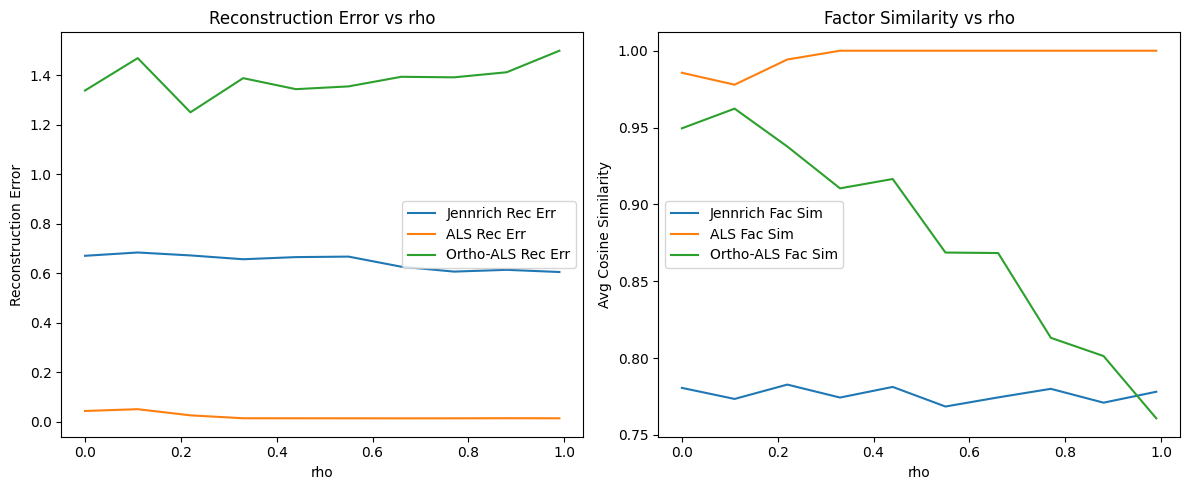

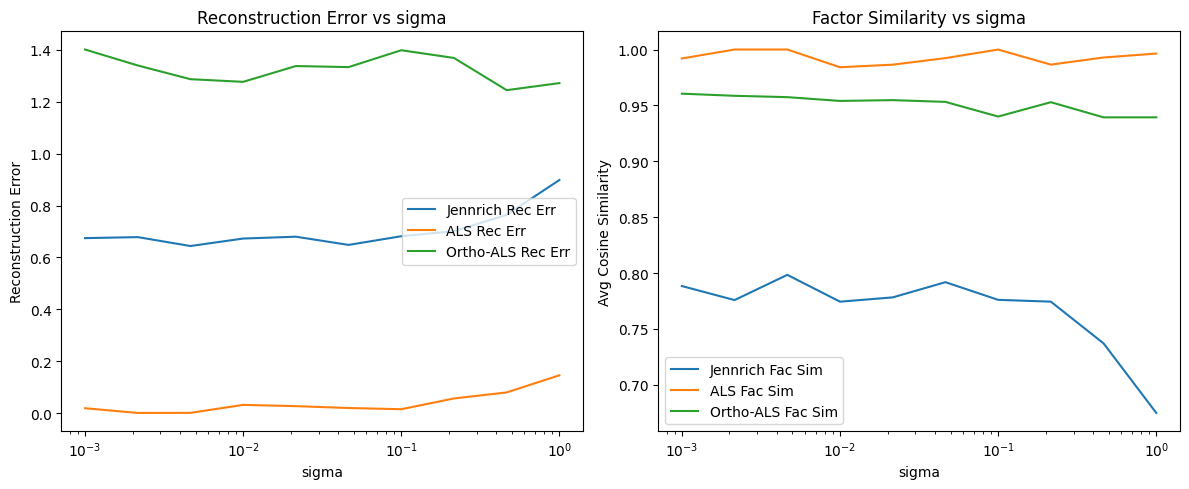

Mean STD Jennrich Rec Err: 1.413197354852415e-13
Mean STD ALS Rec Err: 0.033733900013791424
Mean STD Ortho-ALS Rec Err: 0.2717864286101811
Mean STD Jennrich Fac Sim: 8.774502125999047e-14
Mean STD ALS Fac Sim: 0.012964850170155867
Mean STD Ortho-ALS Fac Sim: nan


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_23687/3729701772.py:314: RuntimeWarning: Mean of empty slice
  print('Mean STD Ortho-ALS Fac Sim:', np.nanmean(var_o_fac))


In [9]:
import numpy as np
from scipy.linalg import eig, pinv
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

def khatri_rao(P, Q):
    d1, k = P.shape
    d2, _ = Q.shape
    return np.hstack([np.kron(P[:, i], Q[:, i])[:, np.newaxis] for i in range(k)])

def reconstruct_tensor(A, B, C):
    d, k = A.shape
    T = np.zeros((d, d, d))
    for i in range(k):
        T += np.outer(A[:, i], B[:, i])[:, :, np.newaxis] * C[:, i]
    return T

def fro_norm(X):
    return np.sqrt(np.sum(X**2))

def reconstruction_error(true_T, hat_T):
    return fro_norm(true_T - hat_T) / fro_norm(true_T)

def factor_recovery_error(true_F, hat_F):
    d, k = true_F.shape
    true_norm = true_F / np.linalg.norm(true_F, axis=0)
    hat_norm = hat_F / np.linalg.norm(hat_F, axis=0)
    cos_matrix = np.abs(true_norm.T @ hat_norm)
    cost = -cos_matrix
    row_ind, col_ind = linear_sum_assignment(cost)
    mean_cos = np.mean(cos_matrix[row_ind, col_ind])
    return mean_cos  # Higher is better; for error, could use 1 - mean_cos if desired

def jennrich(T_noisy, k):
    d = T_noisy.shape[0]
    u = np.random.randn(d)
    v = np.random.randn(d)
    M1 = np.sum(u[:, np.newaxis, np.newaxis] * T_noisy, axis=2)
    M2 = np.sum(v[:, np.newaxis, np.newaxis] * T_noisy, axis=2)
    try:
        vals, vl, vr = eig(M1, M2, left=True, right=True)
        if np.any(np.imag(vals) != 0):
            return None, None, None
        vl = np.real(vl)
        vr = np.real(vr)
        A_hat = np.linalg.inv(vl).T
        B_hat = np.linalg.inv(vr).T
        T3 = np.transpose(T_noisy, (2, 0, 1)).reshape(d, d * d)
        kr = khatri_rao(A_hat, B_hat)
        C_hat = T3 @ pinv(kr.T)
        return A_hat, B_hat, C_hat
    except:
        return None, None, None

def cp_als(T, k, max_iter=50, tol=1e-4):
    d = T.shape[0]
    A = np.random.randn(d, k)
    B = np.random.randn(d, k)
    C = np.random.randn(d, k)
    norm = lambda X: np.maximum(np.linalg.norm(X, axis=0, keepdims=True), 1e-10)
    A = A / norm(A)
    B = B / norm(B)
    C = C / norm(C)
    for _ in range(max_iter):
        # Update A
        kr = khatri_rao(B, C)
        T1 = T.reshape(d, d * d)
        A = T1 @ kr @ pinv(kr.T @ kr)
        A = A / norm(A)
        # Update B
        kr = khatri_rao(A, C)
        T2 = np.transpose(T, (1, 0, 2)).reshape(d, d * d)
        B = T2 @ kr @ pinv(kr.T @ kr)
        B = B / norm(B)
        # Update C
        kr = khatri_rao(A, B)
        T3 = np.transpose(T, (2, 0, 1)).reshape(d, d * d)
        C = T3 @ kr @ pinv(kr.T @ kr)
        C = C / norm(C)
    return A, B, C

def ortho_als(T, k, max_iter=50, tol=1e-4):
    """
    Ortho-ALS for CP decomposition.
    Adds an orthogonalization (QR) step after each factor update.

    Args:
        T: d x d x d tensor
        k: rank
        max_iter: number of ALS iterations
        tol: stopping tolerance (optional, usually not needed)

    Returns:
        A, B, C: factor matrices (d x k)
    """
    d = T.shape[0]

    # Random initialization
    A = np.random.randn(d, k)
    B = np.random.randn(d, k)
    C = np.random.randn(d, k)

    # Normalize columns
    def normalize(X):
        return X / np.maximum(np.linalg.norm(X, axis=0, keepdims=True), 1e-10)

    A = normalize(A)
    B = normalize(B)
    C = normalize(C)

    # Unfoldings
    T1 = T.reshape(d, d * d)
    T2 = np.transpose(T, (1, 0, 2)).reshape(d, d * d)
    T3 = np.transpose(T, (2, 0, 1)).reshape(d, d * d)

    for it in range(max_iter):

        # --- Update A ---
        kr = khatri_rao(B, C)        # (d*d) x k
        A = T1 @ kr @ pinv(kr.T @ kr)
        # Ortho step: QR with economic mode
        A, _ = np.linalg.qr(A)
        A = A[:, :k]                 # take first k orthonormal cols
        A = normalize(A)

        # --- Update B ---
        kr = khatri_rao(A, C)
        B = T2 @ kr @ pinv(kr.T @ kr)
        B, _ = np.linalg.qr(B)
        B = B[:, :k]
        B = normalize(B)

        # --- Update C ---
        kr = khatri_rao(A, B)
        C = T3 @ kr @ pinv(kr.T @ kr)
        C, _ = np.linalg.qr(C)
        C = C[:, :k]
        C = normalize(C)

    return A, B, C

def generate_data(d, k, sigma, rho=0):
    A = np.random.randn(d, k)
    B = np.random.randn(d, k)
    if rho == 0:
        C = np.random.randn(d, k)
    else:
        Sigma = rho * np.ones((k, k)) + (1 - rho) * np.eye(k)
        L = np.linalg.cholesky(Sigma)
        C = np.random.randn(d, k) @ L
    norm = lambda X: np.maximum(np.linalg.norm(X, axis=0, keepdims=True), 1e-10)
    A = A / norm(A)
    B = B / norm(B)
    C = C / norm(C)
    T = reconstruct_tensor(A, B, C)
    E = np.random.randn(d, d, d)
    if fro_norm(T) > 0:
        E = E / fro_norm(E) * fro_norm(T) * sigma
    T_noisy = T + E
    return T, T_noisy, A, B, C

# Experiment 1: Bad Conditioning Test
def experiment1(d=20, k=3, sigma=0.1, num_reps=50):
    rhos = np.linspace(0, 0.99, 10)
    jenn_rec = []
    als_rec = []
    ortho_rec = []
    jenn_fac = []
    als_fac = []
    ortho_fac = []
    for rho in rhos:
        rec_j, fac_j, rec_a, fac_a, rec_o, fac_o = [], [], [], [], [], []
        for _ in range(num_reps):
            T, T_noisy, A_true, B_true, C_true = generate_data(d, k, sigma, rho)
            # Jennrich
            A_hat, B_hat, C_hat = jennrich(T_noisy, k)
            if A_hat is not None:
                hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
                rec_j.append(reconstruction_error(T, hat_T))
                fac_j.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
            # ALS
            A_hat, B_hat, C_hat = cp_als(T_noisy, k)
            hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
            rec_a.append(reconstruction_error(T, hat_T))
            fac_a.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
            # Ortho-ALS
            A_hat, B_hat, C_hat = ortho_als(T_noisy, k)
            hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
            rec_o.append(reconstruction_error(T, hat_T))
            fac_o.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
        jenn_rec.append(np.mean(rec_j) if rec_j else np.nan)
        als_rec.append(np.mean(rec_a))
        ortho_rec.append(np.mean(rec_o))
        jenn_fac.append(np.mean(fac_j) if fac_j else np.nan)
        als_fac.append(np.mean(fac_a))
        ortho_fac.append(np.mean(fac_o))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(rhos, jenn_rec, label='Jennrich Rec Err')
    ax1.plot(rhos, als_rec, label='ALS Rec Err')
    ax1.plot(rhos, ortho_rec, label='Ortho-ALS Rec Err')
    ax1.legend()
    ax1.set_xlabel('rho')
    ax1.set_ylabel('Reconstruction Error')
    ax1.set_title('Reconstruction Error vs rho')

    ax2.plot(rhos, jenn_fac, label='Jennrich Fac Sim')
    ax2.plot(rhos, als_fac, label='ALS Fac Sim')
    ax2.plot(rhos, ortho_fac, label='Ortho-ALS Fac Sim')
    ax2.legend()
    ax2.set_xlabel('rho')
    ax2.set_ylabel('Avg Cosine Similarity')
    ax2.set_title('Factor Similarity vs rho')

    plt.tight_layout()
    plt.savefig('exp1.png')
    plt.show()

# Experiment 2: Noise Floor
def experiment2(d=20, k=3, rho=0, num_reps=50):
    sigmas = np.logspace(-3, 0, 10)
    jenn_rec = []
    als_rec = []
    ortho_rec = []
    jenn_fac = []
    als_fac = []
    ortho_fac = []
    for sigma in sigmas:
        rec_j, fac_j, rec_a, fac_a = [], [], [], [] 
        rec_o, fac_o = [], []
        for _ in range(num_reps):
            T, T_noisy, A_true, B_true, C_true = generate_data(d, k, sigma, rho)
            A_hat, B_hat, C_hat = jennrich(T_noisy, k)
            if A_hat is not None:
                hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
                rec_j.append(reconstruction_error(T, hat_T))
                fac_j.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
            A_hat, B_hat, C_hat = cp_als(T_noisy, k)
            hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
            rec_a.append(reconstruction_error(T, hat_T))
            fac_a.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
            A_hat, B_hat, C_hat = ortho_als(T_noisy, k)
            hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
            rec_o.append(reconstruction_error(T, hat_T))
            fac_o.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
        jenn_rec.append(np.mean(rec_j) if rec_j else np.nan)
        als_rec.append(np.mean(rec_a))
        ortho_rec.append(np.mean(rec_o))
        jenn_fac.append(np.mean(fac_j) if fac_j else np.nan)
        als_fac.append(np.mean(fac_a))
        ortho_fac.append(np.mean(fac_o))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(sigmas, jenn_rec, label='Jennrich Rec Err')
    ax1.plot(sigmas, als_rec, label='ALS Rec Err')
    ax1.plot(sigmas, ortho_rec, label='Ortho-ALS Rec Err')
    ax1.legend()
    ax1.set_xscale('log')
    ax1.set_xlabel('sigma')
    ax1.set_ylabel('Reconstruction Error')
    ax1.set_title('Reconstruction Error vs sigma')

    ax2.plot(sigmas, jenn_fac, label='Jennrich Fac Sim')
    ax2.plot(sigmas, als_fac, label='ALS Fac Sim')
    ax2.plot(sigmas, ortho_fac, label='Ortho-ALS Fac Sim')
    ax2.legend()
    ax2.set_xscale('log')
    ax2.set_xlabel('sigma')
    ax2.set_ylabel('Avg Cosine Similarity')
    ax2.set_title('Factor Similarity vs sigma')

    plt.tight_layout()
    plt.savefig('exp2.png')
    plt.show()

# Experiment 3: Initialization Sensitivity
def experiment3(d=20, k=3, sigma=0.1, rho=0.5, num_inits=20, num_reps=20):
    var_j_rec, var_a_rec, var_j_fac, var_a_fac = [], [], [], [] 
    var_o_rec, var_o_fac = [], []
    for _ in range(num_reps):
        T, T_noisy, A_true, B_true, C_true = generate_data(d, k, sigma, rho)
        # Jennrich
        rec_js, fac_js = [], []
        for _ in range(num_inits):
            A_hat, B_hat, C_hat = jennrich(T_noisy, k)
            if A_hat is not None:
                hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
                rec_js.append(reconstruction_error(T, hat_T))
                fac_js.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
        var_j_rec.append(np.std(rec_js) if rec_js else np.nan)
        var_j_fac.append(np.std(fac_js) if fac_js else np.nan)
        # ALS
        rec_as, fac_as = [], []
        for _ in range(num_inits):
            A_hat, B_hat, C_hat = cp_als(T_noisy, k)
            hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
            rec_as.append(reconstruction_error(T, hat_T))
            fac_as.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
        var_a_rec.append(np.std(rec_as))
        var_a_fac.append(np.std(fac_as))
        # Ortho-ALS
        rec_os, fac_os = [], []
        for _ in range(num_inits):
            A_hat, B_hat, C_hat = ortho_als(T_noisy, k)
            hat_T = reconstruct_tensor(A_hat, B_hat, C_hat)
            rec_os.append(reconstruction_error(T, hat_T))
            fac_os.append((factor_recovery_error(A_true, A_hat) + factor_recovery_error(B_true, B_hat) + factor_recovery_error(C_true, C_hat)) / 3)
        var_o_rec.append(np.std(rec_os))
    print('Mean STD Jennrich Rec Err:', np.nanmean(var_j_rec))
    print('Mean STD ALS Rec Err:', np.nanmean(var_a_rec))
    print('Mean STD Ortho-ALS Rec Err:', np.nanmean(var_o_rec))
    print('Mean STD Jennrich Fac Sim:', np.nanmean(var_j_fac))
    print('Mean STD ALS Fac Sim:', np.nanmean(var_a_fac))
    print('Mean STD Ortho-ALS Fac Sim:', np.nanmean(var_o_fac))

# Run experiments
experiment1()
experiment2()
experiment3()